# Sentiment Analysis on movie reviews in spanish IMDb

# Exploratory Data Analysis on Text Data

We can read this concept definition on Wikipedia: **"exploratory data analysis (EDA) is an approach to analyzing data sets to summarize their main characteristics, often with visual methods."**. This step is absolutely necessary and has a huge impact on the final result of a model, this analysis will tell us what type of transformation we need to apply on the dataset.

When we face a machine learning problem, we must begin by analyzing the input data set, seeking to identify its characteristics and anomalies. In this post we will explore the dataset, analyze the main features and characteristics of the data and visualize some figures to help us understand how our dataset looks like and how we need to process it for a better performance of our algorithms.

We should spend enough time diving on the data to extract information, or even knowledge, about the scope of our task and an intuition on how to handle and transform it. We will apply and use some commons techniques on data exploration and visualization.

### Importing the libraries

For the very first time, we need to download and install the following libraries that we will use to plot and visualize some interesting resutls

In [ ]:
#!pip install wordcloud
#!pip install gensim
#!pip install pyLDAvis

In [1]:
#Imports of all the packages needed
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# Import the seaborn library, it is a powerful library for plotting and commonly used with matplotlib
import seaborn as sns
sns.set_style("white")
# Import utility functions
import os
import random
from collections import Counter

#Import packages to manipulate and transform the text
import re, string
import nltk
from nltk.tokenize import word_tokenize
import gensim
from gensim.summarization.textcleaner import split_sentences
import unicodedata

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

# Import the wordcloud library
from wordcloud import WordCloud

# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
#Import a package to manage the warnings and ignore them
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


In [2]:
# Import a library to apply LDA analysis on data
#from pyLDAvis import sklearn as sklearn_lda
import pickle 
#import pyLDAvis

We will define some global variables to be use during our analysis:

In [ ]:
# RUN THIS CELL When running out of Colab 
root_folder = "C:/Users/edumu/Google Drive"

In [3]:
# RUN THIS CELL When running ON Colab 
from google.colab import drive
root_folder = '/content/drive/My Drive'

In [4]:
#Set the path where the datafiles are stored
# Global parameters
#root_folder='/content/drive'
data_folder_name='datasets/IMdb_reviews_spanish'
model_folder_name='Projects/transformer_sentiment_analysis_spanish/model/'
checkpoint_folder = "Projects/transformer_sentiment_analysis_spanish/ckpt/"
output_folder = 'Projects/transformer_sentiment_analysis_spanish/data_analysis'
train_filename='IMDB Dataset SPANISH.csv'
#test_filename= 'test_descriptions.csv'

# Variable for data directory
data_path = os.path.abspath(os.path.join(root_folder, data_folder_name))
train_filenamepath = os.path.abspath(os.path.join(data_path, train_filename))
#test_filenamepath = os.path.abspath(os.path.join(data_path, test_filename))
checkpoint_path = os.path.abspath(os.path.join(root_folder, checkpoint_folder))
model_path = os.path.abspath(os.path.join(root_folder, model_folder_name))
output_path = os.path.abspath(os.path.join(root_folder, output_folder))

#Define some global variables for text processing
punc = string.punctuation
punctuation = string.punctuation.replace('.', '')
#Create the list of stopwords
stopwords = nltk.corpus.stopwords.words('english')

### Loading the dataset
First step, load the whole dataset hosted locally

In [5]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# To use read_excel
#!pip install xlrd

In [6]:
# Load the data from the file system
reviews = pd.read_csv(train_filenamepath, header=0, usecols=[2,4])
print(reviews.head(5))
print('Num rows: ',len(reviews))

                                           review_es sentimiento
0  Uno de los otros críticos ha mencionado que de...    positivo
1  Una pequeña pequeña producción.La técnica de f...    positivo
2  Pensé que esta era una manera maravillosa de p...    positivo
3  Básicamente, hay una familia donde un niño peq...    negativo
4  El "amor en el tiempo" de Petter Mattei es una...    positivo
Num rows:  50000


# Data Definition
**Describe DATA**

Lets show the data structure and an example of the dataset:

In [6]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_es    50000 non-null  object
 1   sentimiento  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
print(reviews['review_es'][25],'\n',reviews['sentimiento'][25],'\n')
print(reviews['review_es'][24],'\n',reviews['sentimiento'][24],'\n')

La historia de Karen Carpenter muestra un poco más sobre la vida compleja de Cantante Karen Carpenter.Aunque falla en dar hechos precisos, y detalles. Cynthia gibb (Portes Karen) no fue una buena elección.Ella es una buena actriz, pero juega muy ingenuamente y tipo de carpintero karen tonto.Creo que el papel necesitaba un carácter más fuerte.Alguien con una personalidad más fuerte. El papel de Fletcher, ya que Agnes Carpenter es excelente, ella hace un gran trabajo como la madre de Karen. Tiene grandes canciones, que podrían haberse incluido en un álbum de banda sonora.Lamentablemente, no lo fueron, aunque esta película estaba en la cima de las calificaciones en Estados Unidos y otros países. 
 positivo 

¡Esta fue la peor película que vi en WorldFest y también recibió la menor cantidad de aplausos después!Solo puedo pensar que está recibiendo dicho reconocimiento basado en la cantidad de actores conocidos en la película.Es genial ver a J.BEALS, pero ella está solo en la película duran

We can observe that there are some weird characters, we need to transform the text codification to ASCII but our first step is to get a simple view of the number of registries: 

# Descriptive statictics

First of all, we extract the basics statistics: count of rows, unique rows, frequencies,... This atributes in the text data will tell us if we need to remove repeated rows or how many rows contains null values in any column. 

In [7]:
# Count the number of examples and unique values
print('Dataset examples: ', len(reviews))
reviews.describe()

Dataset examples:  50000


,review_es,sentimiento
count,50000,50000
unique,49599,2
top,"Hilarante, limpio, alegre y digno de cita.¿Qué...",positivo
freq,4,25000


**Conclusion from statistics**

Reading the previous table we can observe that there are some rows with a null value or repetaed in the variable `description`. So our first step would be to drop those rows. 

Check for null values:

In [8]:
reviews.isnull().sum()

review_es      0
sentimiento    0
dtype: int64

In [ ]:
# Remove rows with null values
reviews.dropna(inplace=True)
#Recreate the dataframe index
reviews.reset_index(drop=True,inplace=True)
reviews.describe()

,name,description
count,33613,33613
unique,23428,31593
top,PRINTED DRESS,Short sleeve T-shirt with a round neckline and...
freq,61,48


Lets create a new dataframe with the variables we are interested in analyzing.

In [9]:
# we are using the text variable as the summary and the ctext as the source text
dataset = reviews.copy()
dataset.head(5)

,review_es,sentimiento
0,Uno de los otros críticos ha mencionado que de...,positivo
1,Una pequeña pequeña producción.La técnica de f...,positivo
2,Pensé que esta era una manera maravillosa de p...,positivo
3,"Básicamente, hay una familia donde un niño peq...",negativo
4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


## Cleaning the data

As we mention before, we to clean our text and transform to ASCII code.


In [10]:
def remove_URL(text):
    ''' Remove URLs from the text'''
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

# Remove html tag
def remove_html(text):
    ''' Remove HTML tags from the text'''
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_mention(text):
    ''' Remove mentions from the text'''
    url = re.compile(r'@\S*')
    return url.sub(r'',text)

def remove_mult_spaces(text):
    ''' Reduce multispace to one single space'''
    re_mult_space = re.compile(r"  *") # replace multiple spaces with just one
    return re_mult_space.sub(r' ', text)

def remove_non_character(text):
    ''' Remove some non alphanumeric characters'''
    url = re.compile(r'\x89\S*|\x9b\S*|\x92\S*|x93\S*|\x8a\S*|\x8f\S*|\x9d\S*|\x8c\S*|\x91\S*|\x87\S*|\x88\S*|\x82\S*')
    #url = re.compile(r'\x\d+\S*')
    return url.sub(r'',text)

def remove_punctuation(text, punctuation):
    ''' Remove punctuation from the text'''
    table=str.maketrans('','',punctuation)
    return text.translate(table)

def remove_emoji(text):
    ''' Remove emojis from the text'''
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_CTL(text):
    ''' Remove end of line from the text'''
    url = re.compile(r'\n')
    return url.sub(r' ',text)

def remove_hashtag(text):
    ''' Remove hashtags from the text'''
    url = re.compile(r'#\S*')
    return url.sub(r'',text)

def unicode_to_ascii(s):
    ''' Transform unicode symbols to ascii'''
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                    if unicodedata.category(c) != 'Mn')


In [11]:
def clean_text(text):
    ''' Clean the input text using common techniques'''
    new_text = text.map(lambda x: x.lower())
    new_text=new_text.apply(lambda x : unicode_to_ascii(x))
    #new_text=new_text.apply(lambda x : replace_mapping(x, special_mapping))
    new_text=new_text.apply(lambda x : remove_URL(x))
    new_text=new_text.apply(lambda x : remove_html(x))
    new_text=new_text.apply(lambda x : remove_emoji(x))
    new_text=new_text.apply(lambda x : remove_CTL(x))
    #new_text=new_text.apply(lambda x : expand_contractions(x,contraction_mapping))
    new_text=new_text.apply(lambda x : remove_non_character(x))
    new_text=new_text.apply(lambda x : remove_mention(x))
    new_text=new_text.apply(lambda x : remove_hashtag(x))
    #new_text=new_text.apply(lambda x : remove_punctuation(x, punctuation))
    new_text=new_text.apply(lambda x : remove_mult_spaces(x))
    return new_text


In [12]:
# Apply the cleaning functions to the review text
data_text = clean_text(dataset['review_es'])
#Checking the results
print(len(data_text))

50000


In [13]:
# Print some examples and statistics
print(dataset.head(5))
print(dataset.describe())

                                           review_es sentimiento
0  Uno de los otros críticos ha mencionado que de...    positivo
1  Una pequeña pequeña producción.La técnica de f...    positivo
2  Pensé que esta era una manera maravillosa de p...    positivo
3  Básicamente, hay una familia donde un niño peq...    negativo
4  El "amor en el tiempo" de Petter Mattei es una...    positivo
                                                review_es sentimiento
count                                               50000       50000
unique                                              49599           2
top     Hilarante, limpio, alegre y digno de cita.¿Qué...    positivo
freq                                                    4       25000


In [14]:
# Save the cleaned and tokenize text in the dataframe
dataset['review_es']=data_text
#dataset['name']=data_headlines
print(dataset['review_es'][1],'\n',dataset['sentimiento'][1],'\n')

una pequena pequena produccion.la tecnica de filmacion es muy incuestionable, muy antigua, la moda de la bbc y le da una sensacion de realismo reconfortante, y, a veces, incomodo, y, a veces, a la pieza.los actores son extremadamente bien elegidos, michael sheen, no solo "tiene todo el polari", ¡pero tiene todas las voces por palmaditas!realmente puede ver la edicion perfecta guiada por las referencias a las entradas del diario de williams, no solo vale la pena la observacion, pero es una pieza imperrementemente escrita y realizada.una produccion magistral sobre uno de los grandes maestros de la comedia y su vida.el realismo realmente llega a casa con las pequenas cosas: la fantasia del guardia que, en lugar de usar las tecnicas de "sueno" tradicionales permanece solido, entonces desaparece.se desempena nuestro conocimiento y nuestros sentidos, particularmente con las escenas relacionadas con orton y halliwell y los conjuntos (particularmente de su apartamento con murales de halliwell 

# Exploring relevant features in the data

In this section we will create some additional features that provide relevant information about the composition of our texts. The following list explains different ideas for creating new features:

#### Statistical Count Features from headlines and text
- Sentence Count - Total number of sentences in the text
- Word Count - Total number of words in the text
- Character Count - Total number of characters in the text excluding spaces
- Sentence density - Number of sentences relative to the number of words
- Word Density - Average length of the words used in the text
- Punctuation Count - Total number of punctuations used in the text
- Stopwords Count - Total number of common stopwords in the text


Lets define some helpers function 

In [15]:
def count_stopwords(text, stopwords):
    ''' Return the number of stopwords in the text
        Input:
            - text: string
            - stopwords: list of string, containing the stopwords
        Output:
            - int, number of stopwords in the text argument
    '''
    word_tokens = word_tokenize(text) #splitta i pezzi
    stopwords_x = [w for w in word_tokens if w in stopwords]
    
    return len(stopwords_x)

It is time to calculate every new feature previously listed. 

In [16]:
# Create a new variable containing the number of sentences in the text
dataset['review_sent_count'] = dataset['review_es'].apply(lambda x : len(split_sentences(x)))
# Create a new variable containing the number of word in the text
dataset['review_word_count'] = dataset['review_es'].apply(lambda x : len(x.split()))
# Create a new variable containing the number of characters in the text
dataset['review_char_count'] = dataset['review_es'].apply(lambda x : len(x.replace(" ","")))
# Create a new variable containing the density of words in the text
dataset['review_word_density'] = dataset['review_word_count'] / (dataset['review_char_count'] + 1)
# Create a new variable containing the density of sentences in the text
dataset['review_sent_density'] = dataset['review_sent_count'] / (dataset['review_word_count'] + 1)
# Create a new variable containing the number of punctuations in the text
dataset['review_punc_count'] = dataset['review_es'].apply(lambda x : len([a for a in x if a in punc]))

# Stopwords
# Create a new variable containing the number of stopwords in the text
dataset['review_stopw_count'] =  dataset['review_es'].apply(lambda x : count_stopwords(x, stopwords))
# Create a new variable containing the density of stopwords in the text
dataset['review_stopw_density'] = dataset['review_stopw_count'] / (dataset['review_word_count'] + 1)

## Analyze the feature distributions on the description variable

Now that we have calculated the new features, we can analyze the descriptive statistics to identify the main insights on the data distribution and outliers.

In [17]:
dataset[['review_sent_count', 'review_word_count', 'review_char_count', 'review_stopw_count', 'review_punc_count']].describe()


,review_sent_count,review_word_count,review_char_count,review_stopw_count,review_punc_count
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,9.292540,237.218340,1161.661080,22.152280,36.786800
std,9.818707,179.517514,858.494285,52.095497,28.434992
min,1.000000,6.000000,33.000000,0.000000,0.000000
25%,2.000000,123.000000,624.000000,7.000000,18.000000
50%,5.000000,172.000000,865.500000,12.000000,28.000000
75%,15.000000,293.000000,1419.000000,20.000000,46.000000
max,132.000000,2450.000000,11016.000000,1123.000000,560.000000


Summarizing:
- **WRITE CONCLUSION**

Let's dive in these features to get a better understanding by plotting some figures

**Plotting box plots and histograms about text variable**

In [18]:
# We declare a new dataframe for plotting porpouses
#data=dataset

# Create a dictionary to title the columns based on their names
labels_dict={'review_word_count': 'Word Count of Summaries',
             'review_char_count': 'Char Count of Summaries',
             'review_word_density': 'Word Density of Summaries',
             'review_punc_count': 'Punctuation Count of Summaries',
             'review_sent_count': 'Sentence Count of Summaries',
             'reviewe_sent_density': 'Sentence Density of Summaries',
             'review_stopw_count': 'Stopwords Count of Summaries',
             'ADJ': 'adjective','ADP': 'adposition', 'ADV': 'adverb','CONJ': 'conjunction',
             'DET': 'determiner','NOUN': 'noun', 
             'review_unknown_count': 'Unknown words in Summaries',}

Define some functions to plot our graphics or figures:

In [19]:
def plot_boxplots(data, plot_vars, labels, figsize):
    ''' Plot a box-plot of the variables in the plot_vars list using the labels and a size of figesize
        Input:
        - data: a dataframe, containing the data points to plot
        - plot_vars: a (1,x) array, containig the columns to plot
        - labels: a dctionary, to map the column names to its label
        - figsize: a tuple, indicating the size of the figure
    '''
    
   # We need to identify is this a matrix or a vector
    if plot_vars.ndim == 1:
        nrows=1
        ncols = plot_vars.shape[0]
    else:
        nrows= plot_vars.shape[0]
        ncols = plot_vars.shape[1]

    #Create a figure and its axes for the dimensions defined
    f, axes = plt.subplots(nrows, ncols, sharey=False, figsize=(15,5))
    #For every variable in the plot_vars
    for i in range(nrows):
        for j in range(ncols):
            # If the column name is defined we plot it
            if plot_vars[i,j]!=None:
                if axes.ndim>1:
                    #Set the title
                    axes[i,j].set_title(labels[plot_vars[i,j]])
                    axes[i,j].grid(True)
                    #Set x ticks
                    axes[i,j].tick_params(
                        axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,         # ticks along the top edge are off
                        labelbottom=False)
                    # Plot a boxplot for the column in plot_vars
                    axes[i,j].boxplot(data[plot_vars[i,j]])
                else:
                    #Set the title
                    axes[j].set_title(labels[plot_vars[i,j]])
                    axes[j].grid(True)
                    #Set x ticks
                    axes[j].tick_params(
                        axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,         # ticks along the top edge are off
                        labelbottom=False)
                    # Plot a boxplot for the column in plot_vars
                    axes[j].boxplot(data[plot_vars[i,j]])
                
            else:
                axes[i,j].set_visible(False)
    # Adjust the plots for a better visualization
    f.tight_layout()
    plt.show() 


def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def plot_histograms(data, plot_vars, xlim, labels, figsize):
    ''' Function to plot the histograms of the variables in plot_vars
        Input:
        - data: a dataframe, containing the data points to plot
        - plot_vars: a (1,x) array, containig the columns to plot
        - xlim: a list, define the max x value for every column to plot
        - labels: a dctionary, to map the column names to its label
        - figsize: a tuple, indicating the size of the figure
    '''
    #Set some parameters
    kwargs = dict(hist_kws={'alpha':.7}, kde_kws={'linewidth':2})

    #cmap = get_cmap(plot_vars.shape[1])
    # Create the figure and axes
    fig, axes = plt.subplots(plot_vars.shape[0], plot_vars.shape[1], figsize=figsize, sharey=False, dpi=100)
    #For every variable in plot_vars
    for i in range(plot_vars.shape[1]):
        # Plot the histogram 
        sns.distplot(data[plot_vars[0,i]] , color=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1),), 
                     ax=axes[i], axlabel=labels[plot_vars[0,i]], bins= 50, norm_hist = True)
        #For a better visualization we set the x limit
        axes[i].set_xlim(left=0, right=xlim[i])
        
    fig.tight_layout()

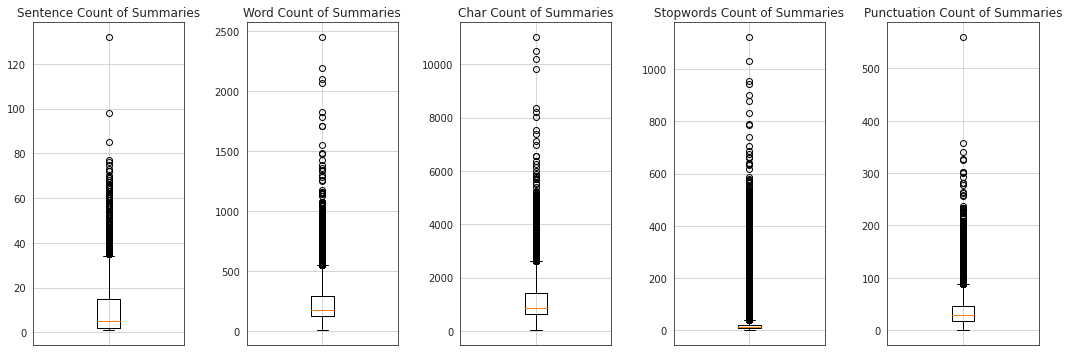

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

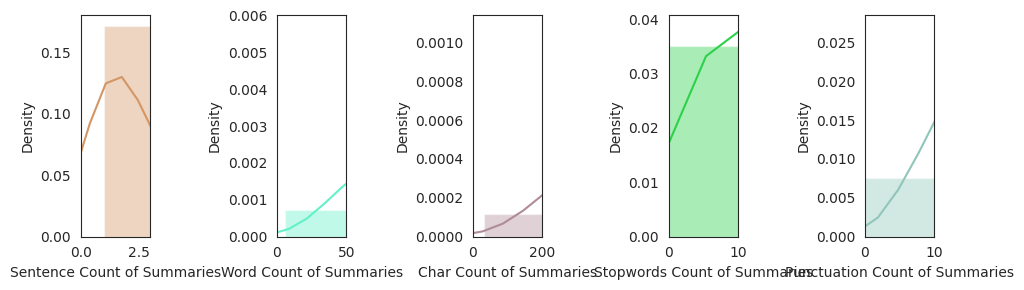

In [20]:
#Set the columns to plot
plot_vars=np.array([['review_sent_count', 'review_word_count', 'review_char_count','review_stopw_count','review_punc_count']])
# Plot the boxplots for the interesting columns
plot_boxplots(dataset, plot_vars, labels_dict, figsize=(10,3))
# Plot the histograms 
plot_histograms(dataset, plot_vars, [3, 50, 200, 10, 10], labels_dict, figsize=(10,3))

Above we have plotted the histograms of our features. The count of rows with outliers values is a small number, we can consider removing them but it does not look a great deal. The count of words looks like a left skewed distribution, 75% of rows in the range 55–60 words and the count of char is a normal distribution. We do not identify weird examples or data distributions. 

# Categorizing and Tagging Words
Another group of features we can inspect in text data are the Part-Of-Speech tagging:

*The process of classifying words into their parts of speech and labeling them accordingly is known as part-of-speech tagging, POS-tagging, or simply tagging. Parts of speech are also known as word classes or lexical categories... The collection of tags used for a particular task is known as a tagset. Our emphasis in the next section is on exploiting tags, and tagging text automatically.*

       Natural Language Processing with Python, by S. Bird, E. Klein and E. Loper [1]

Our target in the next section is to identify the POS tags and analyze its distribution on the dataset. Maybe we can observe any interesting behavior but it is not frequent.

Tag Meaning English Examples:
- ADJ, adjective: new, good, high, special, big, local
- ADP,adposition:on, of, at, with, by, into, under
- ADV, adverb: really, already, still, early, now
- CONJ, conjunction: and, or, but, if, while, although
- DET, determiner or article: the, a, some, most, every, no, which
- NOUN, noun: year, home, costs, time, Africa
- NUM,numeral: twenty-four, fourth, 1991, 14:24
- PRT, particle: at, on, out, over per, that, up, with
- PRON, pronoun: he, their, her, its, my, I, us
- VERB, verb: is, say, told, given, playing, would
- ., punctuation marks:. , ; !
- X, othe: ersatz, esprit, dunno, gr8, univeristy

In [21]:
def get_pos_tags(sentences, tagset='universal'):
    ''' Extract the part-of-speech taggings of the sentence
        Input:
        - sentence: string, sentence to tag
        - tagset: string, tagset or the set of tags to search for
    '''
    #Create the Dataframe to store the count of tags
    df = pd.DataFrame(columns=['ADJ','ADP','ADV','CONJ','DET','NOUN','NUM','PRT','PRON','VERB','.','X'])
    for sent in sentences:
        # Extract the part of Speech tags in the sentence
        pos_tags = Counter([j for i,j in nltk.pos_tag(word_tokenize(sent), tagset='universal')])
        #Appends the pos tags to the dataframe, fill NaN values with 0
        df = df.append(pos_tags, ignore_index=True).fillna(0)

    return df.astype(int)

To help us with this task, the NLTK library defines a function `pos_tag` which receive a list of words as input and return the part-of-speech tag of every word. Then we can plot a histogram to check the distribution:

In [22]:
# Identify the taggings for the text variable
review_text = dataset['review_es'].values
df_text = get_pos_tags(review_text)
df_text.head()

KeyboardInterrupt: ignored

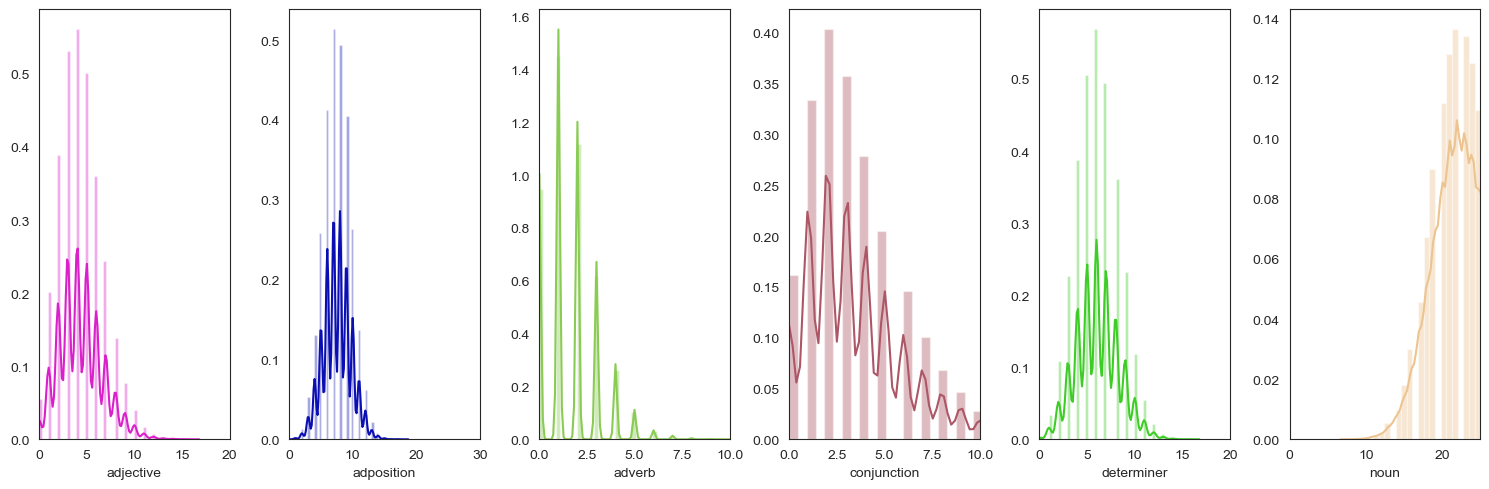

In [ ]:
# Select the columns to plot: those related to pos taggings
plot_vars=np.array([['ADJ','ADP','ADV','CONJ','DET','NOUN']])
# Plot a histograms of the variables 
plot_histograms(df_text, plot_vars, [20, 30, 10, 10, 20, 25], labels_dict, figsize=(15,5))

# Check for unknown words

It may be very common that unknown words are included in our texts, consequently, we should analyze them and you probably have to define how to deal with them. Most of the unknown words are names, surnames, locations or even mispelled words, which we have to decide to correct or not them.

In order to search for these words, we need a vocabulary to compare to. In this case, we use the Glove embeddings, checking if our words are included in those embeddings.

In [ ]:
class GloveVectorizer:
  '''Class to store the vocabulary of our texts, including mappings between words and its integer representation. 
     It also contain the embeddings of the vocab to transform every token or integer value
  '''
  def __init__(self, embedding_file):
    ''' Build the embeddings, load them from a file and store it in a list of embedded vectors '''
    # load in pre-trained word vectors
    print('Loading word vectors...')
    word2vec = {}
    embedding = []
    idx2word = []
    with open(embedding_file, encoding='utf8') as f:
      # is just a space-separated text file in the format:
      # word vec[0] vec[1] vec[2] ...
      for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
        embedding.append(vec)
        idx2word.append(word)
    print('Found %s word vectors.' % len(word2vec))

    # save for later
    self.word2vec = word2vec
    self.embedding = np.array(embedding)
    self.word2idx = {v:k for k,v in enumerate(idx2word)}
    self.V, self.D = self.embedding.shape

  def fit(self, data):
    pass

  def transform(self, data):
    ''' Include the tokens contained in the data in the vocabulary'''
    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    # For every sentence in the data
    for sentence in data:
      tokens = sentence.lower().split() # Extract the words
      vecs = []
      unknowns=0
      # For every word in the setence
      for word in tokens:
        # Include the embedded word in the output list 
        if word in self.word2vec:
          vec = self.word2vec[word]
          vecs.append(vec)
        else:
          unknowns += 1  
      # Calculate the embedding of a data as the mean of the embeddings of every word 
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    #print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X

  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)


In [ ]:
def replace_punctuation(text, punctuation):
    ''' Replace punctuation with whitespace'''
    table=str.maketrans(punctuation, ' '*len(punctuation))
    return text.translate(table)

def unknown_words(text, vocab):
    ''' Return the unknow words found in the text, those not found in the embeddings '''
    tokens = word_tokenize(text)
    unknown = [t for t in tokens if t not in vocab.word2vec]
    
    return unknown


In [ ]:
# Set the filename containing the embeddings
glove_file = 'glove.6B.100d.txt'
glove_filename = os.path.join(data_path, glove_file)
#Load the Glove embeddings
vectorizer = GloveVectorizer(glove_filename)

Loading word vectors...
Found 400000 word vectors.


In [ ]:
# Clean the summary to tokenize and extract the unknown words
dataset['review_unknown_words'] = dataset['review_es'].apply(lambda x : replace_punctuation(x.lower(), string.punctuation))
dataset['review_unknown_words'] = dataset['review_unknown_words'].apply(lambda x : unknown_words(x, vectorizer))
# Count the ocurrencies of unknown words in the summary
dataset['review_unknown_count'] = dataset['review_unknown_words'].apply(lambda x : len(x))

We can show the distribution of the unknown words in our texts to get a fast insight of their relevance:

In [ ]:
# Extract the descriptive statistics for the summary variable
dataset[['review_unknown_count']].describe()

,text_unknown_count,sum_unknown_count
count,54997.000000,54997.000000
mean,0.807008,0.185392
std,1.257573,0.451393
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,20.000000,5.000000


Some examples of unknown words:

In [ ]:
print('Unknown words: ', dataset['review_unknown_words'].values[5])
print('Unknown words: ', dataset['review_unknown_words'].values[50])
print('Unknown words: ', dataset['review_unknown_words'].values[100])

Unknown words:  ['gadot']
Unknown words:  []
Unknown words:  []


Lets plot some histograms to observe how the distribution of unknown words looks like

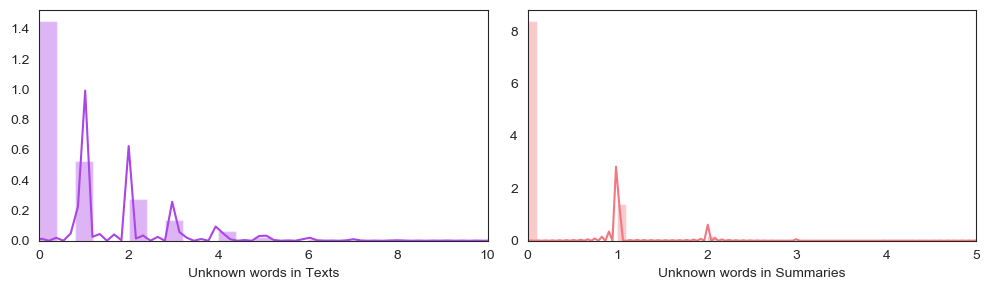

In [ ]:
# Set the columns to plot, the unknown words in the text and summary
plot_vars=np.array([['review_unknown_count']])
# Plot the histograms
plot_histograms(dataset, plot_vars, [10, 5], labels_dict, figsize=(10,3))

- **CONCLUSION**


# Use of stopwords and punctuations

Now that we have a more accurate vision of the composition of our texts, we need to analyze the use of stopwords and punctuation, this analysis will indicate us if these "special type" of characters will be removed or transform when we train our models.

As we did previously, the NLTK library provide us with a list of stopwords for english texts, so we can look for them in our dataset. Now, lets explore the histograms of the count of stopwords and punctuations, to get a better intuition about the texts we are going to work with.

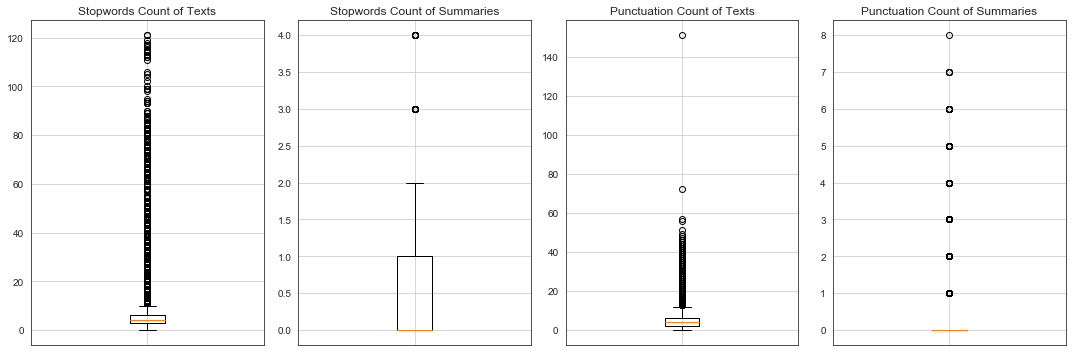

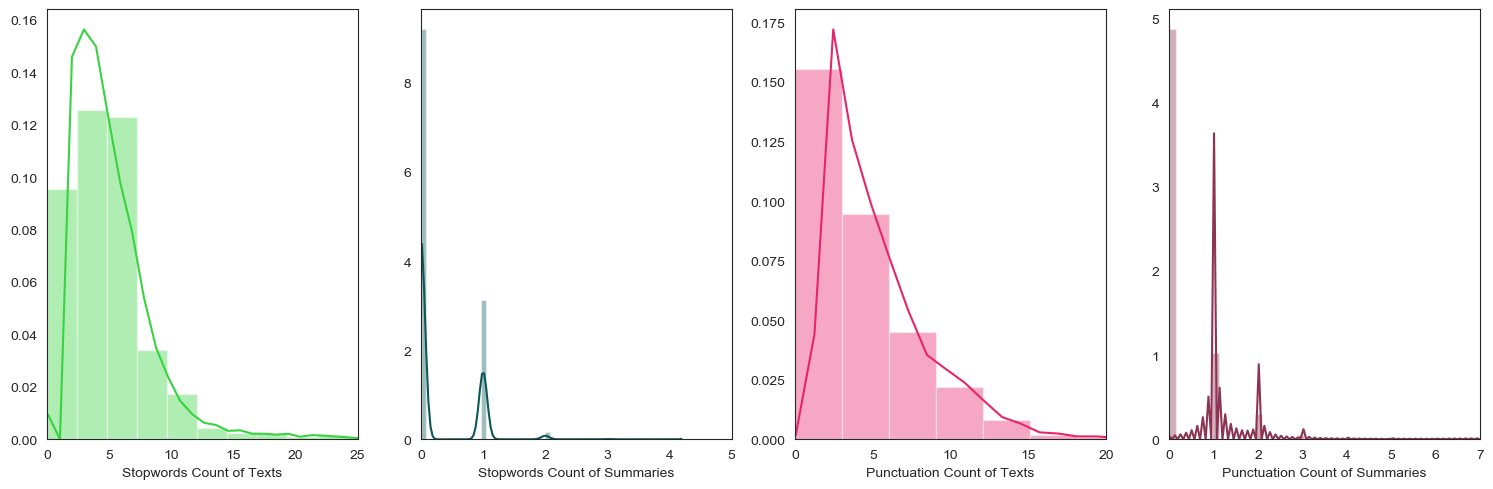

In [ ]:
# Set the columns to plot, those relatives to stopwords and punctuation
plot_vars=np.array([['review_stopw_count', 'review_punc_count']])
# Plot the bosplot and histograms
plot_boxplots(dataset, plot_vars, labels_dict, figsize=(15,5))
plot_histograms(dataset, plot_vars, [25, 5, 20, 7], labels_dict, figsize=(15,5))

Figures are normal, do not show hidden or unexpected patterns

## Cleaning the data

Next, let’s perform a simple preprocessing on the content of the text column to make them more amenable for analysis, and reliable results. To do that, we’ll remove any punctuation, digit and then lowercase the text

In [ ]:
def clean_text(text, stopwords):
    ''' Apply some basic techniques for cleaning a text for an analysis of words
    
    Input:
       - text: text to be cleaned
    Output:
       - result: cleaned text
    '''
    # Lowercase the text
    text = text.lower()
    # Remove any  non-alphabet characters including digits
    pattern =  r'[^a-zA-Z\s]'    
    text = re.sub(pattern, '', text)
    # Remove punctuation
    #table=str.maketrans('','',string.punctuation)
    #text = text.translate(table)
    # Remove the stopwords    
    tokens = nltk.word_tokenize(text)    
    tokens = [token.strip() for token in tokens]    
    text = ' '.join([token for token in tokens if token not in stopwords])
    return text

# Most frequent terms and Wordclouds

The domain or context of our texts will determine the most frequent words, therefore, it is important to verify what those words are and thus identify the domains and confirm that they are the expected ones.

A Wordcloud (or Tag cloud) is a visual representation of text data. It displays a list of words and the importance of each beeing shown with font size or color (the bigger the more frequent). This format is useful for quickly perceiving the most relevant terms on a document or set of documents.

We will draw the wordcloud for the source texts and the summaries to compare if they are very similar, it will allow us to check that the relevant concepts have been correctly extracted in the summaries.

Before building the wordclouds we need to do some basic cleaning in the dataset.

In [ ]:
#Clean the source text and te summary in our dataset
cleaned_text = dataset['review'].apply(lambda x : clean_text(x, stopwords))

Build the wordcloud for source texts

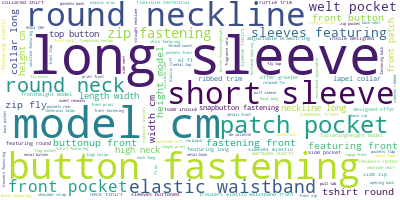

In [ ]:
# Join the different processed texts together.
long_string = ','.join(list(cleaned_text.values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

# Topic Modelling

In our next step, we will learn how to identity which topics are discussed in our texts, this process is called topic modelling. **"In machine learning and natural language processing, a topic model is a type of statistical model for discovering the abstract "topics" that occur in a collection of documents"** by Wikipedia. Using a unsupervised technique, this method tries to find semantic structures in a text in order to classified group of related words in a topic representation.

In particular, we will cover Latent Dirichlet Allocation (LDA): a widely used topic modelling technique. And we will apply LDA to convert our set of source texts to a set of topics.

*There are several existing algorithms you can use to perform the topic modeling. The most common of it are, Latent Semantic Analysis (LSA/LSI), Probabilistic Latent Semantic Analysis (pLSA), and Latent Dirichlet Allocation (LDA)*

[5], "Topic Modeling in Python: Latent Dirichlet Allocation (LDA)" by Shashank Kapadia.


But first, we need to transform our text data to a format that will serve as an input to the LDA model. We convert the text to a vector representation where each word is replaced by an integer. In this case we will apply the CountVectorized method. 

## Count Vectorized

The Count Vectorizeed method replace each word by the count of occurrences of the word in our corpus, group of texts. The result is a document term matrix where most frequents words are assigned with a higher value. 


In [ ]:
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    ''' Draw a barplot showing the tenth most common words in the data
        Input:
        - count_data: tuple, containing pairs of document-term and its ocurrencies in the text
        - count_vectorizer: CountVectorizer object
    '''
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()


In [ ]:
# Initialise the count vectorizer
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
# Apply the count vectorized method to our cleaned data
tf = tf_vectorizer.fit_transform(cleaned_text)
# Build the Document Term Matrix
tf_feature_names = tf_vectorizer.get_feature_names()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
print(doc_term_matrix)

       acacia  accessory  accompanied  ...  zipped  zips  zipup
0           0          0            0  ...       0     0      1
1           0          0            0  ...       0     0      0
2           0          0            0  ...       0     0      0
3           0          0            0  ...       0     0      0
4           0          0            0  ...       0     0      0
...       ...        ...          ...  ...     ...   ...    ...
33608       0          0            0  ...       0     0      0
33609       0          0            0  ...       0     0      0
33610       0          0            0  ...       0     0      0
33611       0          0            0  ...       0     0      0
33612       0          0            0  ...       0     0      0

[33613 rows x 1427 columns]


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


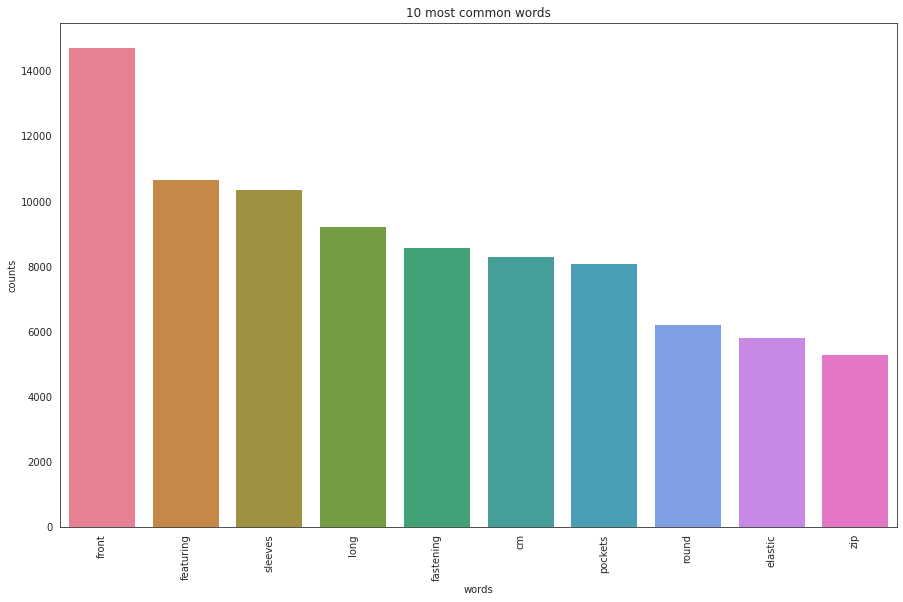

In [ ]:
# Visualise the 10 most common words
plot_10_most_common_words(tf, tf_vectorizer)

## Extract the topic modelling

The next cells will allow us to discover topics in our texts, group of words with co-ocurrences in the documents. The Scikit-learn library provides a function to calculate LDA and return a list with the topic and the tokens that include. In our example, we define 10 topics to discover and show the main 8 elements or words in each one:

In [ ]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    ''' Print the topics detected and the n_top_words that contains
    Input:
       - model: LDA model for the text
       - count_cectorizer: the count vectorizer object
       - n_top_words: the number of words to consider in a topic
    '''
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))


In [ ]:
# Apply the LDA method to discover the topics
lda_model = LDA(n_components=10, learning_method='online', max_iter=500, random_state=0).fit(tf)
# Show the topics and the 8 more relevant words in each topic
no_top_words = 8
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda_model, tf_vectorizer, no_top_words)

Topics found via LDA:

Topic #0:
cm strap length bag width black insole shoulder

Topic #1:
design elastic highwaist waistband trim decorative puff wax

Topic #2:
round print tshirt short neckline sleeves front featuring

Topic #3:
cotton notes fragrance candle ml zara de oz

Topic #4:
front sleeves long collar featuring pockets fastening shirt

Topic #5:
detail fastening back leather dress belt zip applique

Topic #6:
front pockets zip adjustable fastening button elastic side

Topic #7:
cm model height chest back fit lapel side

Topic #8:
print floral two pack one bow cover pull

Topic #9:
sleeves long round neck neckline trims cm model


In our dataset, all news are closely related and include terms like said, india, people. It is hard to clearly identify the topics, but for example, number 4 looks like it is referencing to politicians and number 3 to a sport competition.

## Visualizing the topic modelling results

Visualizing the topics will help us to interpret them, the **pyLDAvis** library plot an interactive figure where each circle corresponds to a topic. The size of the circle represent its importance in the texts and the distance between each circke indicates how similar they are. You can select a topic to display the most relevant words for the topic and the frequency of each word appearing in the topic and the corpus.

The parameter relevance metric λ distinguishes words which are exclusive to the topic (closer to 0) and words with high probability of being included in the selected topic (closer to 1). Playing around with this parameter can help us to assign a "name" to a topic

In [ ]:
LDAvis_data_filepath = os.path.join(output_path+'ldavis_prepared_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
#if 1 == 1:

LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath,'rb') as f:
    LDAvis_prepared = pickle.load(f)
    
pyLDAvis.save_html(LDAvis_prepared, LDAvis_data_filepath+'.html')

C:\Users\edumu\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In the figure shown, we can select a topic and review which relevants words include, its frequency in the dataset. It is easy to compare topics, and search for anomalies or points to mention.

# Analyze data distribution on test files

In [ ]:
# Load the data from the file system
data = pd.read_csv(test_filenamepath)
data.head(5)

,description
0,"Knit midi dress with a V-neckline, straps and ..."
1,"Loose-fitting dress with a round neckline, lon..."
2,Nautical cap with peak.<br/><br/>This item mus...
3,Nautical cap with peak. Adjustable inner strap...
4,Nautical cap with side button detail.<br/><br/...


In [ ]:
# Count the number of examples and unique values
print('Dataset examples: ', len(data))
data.describe()

Dataset examples:  1441


,description
count,1441
unique,1428
top,Duvet cover in 150 thread count cotton with a ...
freq,3


In [ ]:
# Apply the cleaning functions to the source text and summary
data_text = clean_text(data['description'])
# Save the cleaned and tokenize text in the dataframe
data['description']=data_text
print(data['description'][1],'\n')

loose-fitting dress with a round neckline, long sleeves, pleat details and a buttoned opening at the back.height of model: 177 cm / 69.6″ 



In [ ]:
# Create a new variable containing the number of sentences in the text
data['desc_sent_count'] = data['description'].apply(lambda x : len(split_sentences(x)))
# Create a new variable containing the number of word in the text
data['desc_word_count'] = data['description'].apply(lambda x : len(x.split()))
# Create a new variable containing the number of characters in the text
data['desc_char_count'] = data['description'].apply(lambda x : len(x.replace(" ","")))
# Create a new variable containing the density of words in the text
data['desc_word_density'] = data['desc_word_count'] / (data['desc_char_count'] + 1)
# Create a new variable containing the density of sentences in the text
data['desc_sent_density'] = data['desc_sent_count'] / (data['desc_word_count'] + 1)
# Create a new variable containing the number of punctuations in the text
data['desc_punc_count'] = data['description'].apply(lambda x : len([a for a in x if a in punc]))

# Stopwords
# Create a new variable containing the number of stopwords in the text
data['desc_stopw_count'] =  data['description'].apply(lambda x : count_stopwords(x, stopwords))
# Create a new variable containing the density of stopwords in the text
data['desc_stopw_density'] = data['desc_stopw_count'] / (data['desc_word_count'] + 1)

#Print some of the calculated values
print(data[['desc_word_count', 'desc_char_count', 'desc_word_density', 'desc_punc_count']].head(5))
print(data[['desc_sent_count', 'desc_sent_density']].head(5))
print(data[['desc_stopw_count','desc_stopw_density']].head(5))

   desc_word_count  desc_char_count  desc_word_density  desc_punc_count
0               17               83           0.202381                7
1               23              115           0.198276                7
2               14               82           0.168675                2
3                8               47           0.166667                2
4               16               94           0.168421                2
   desc_sent_count  desc_sent_density
0                2           0.111111
1                1           0.041667
2                1           0.066667
3                2           0.222222
4                1           0.058824
   desc_stopw_count  desc_stopw_density
0                 4            0.222222
1                 7            0.291667
2                 4            0.266667
3                 1            0.111111
4                 4            0.235294


In [ ]:
data[['desc_sent_count', 'desc_word_count', 'desc_char_count', 'desc_stopw_count', 'desc_punc_count']].describe()


,desc_sent_count,desc_word_count,desc_char_count,desc_stopw_count,desc_punc_count
count,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000
mean,3.515614,23.700902,120.889660,5.432339,6.160305
std,2.465019,18.280038,89.080922,6.776064,4.782925
min,1.000000,2.000000,12.000000,0.000000,0.000000
25%,1.000000,11.000000,59.000000,2.000000,2.000000
50%,3.000000,19.000000,100.000000,4.000000,5.000000
75%,6.000000,33.000000,161.000000,6.000000,9.000000
max,14.000000,222.000000,1008.000000,94.000000,41.000000


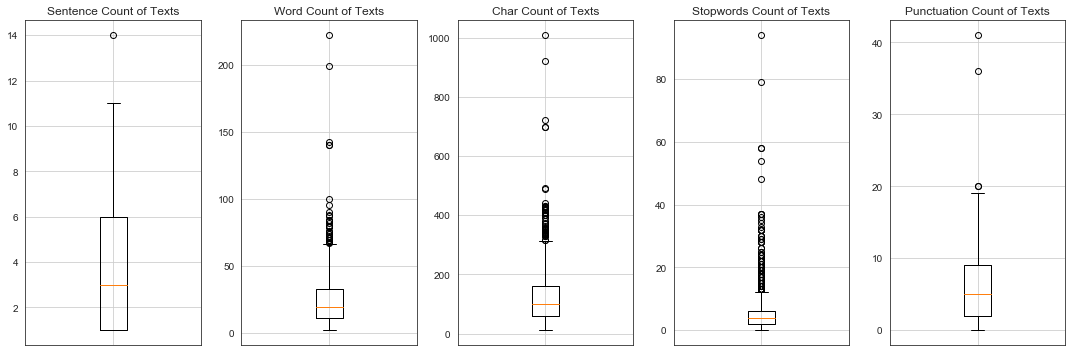

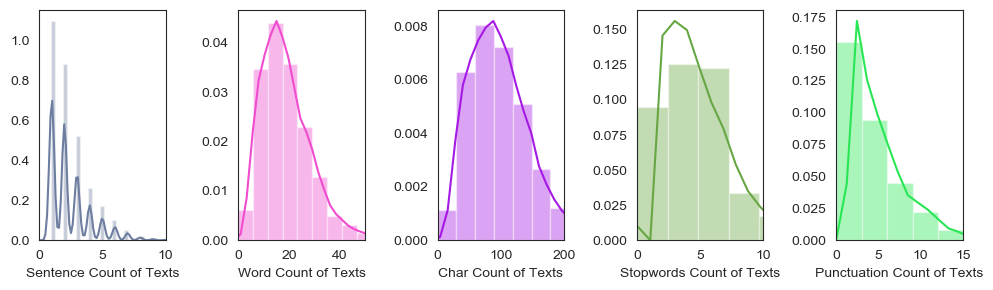

In [ ]:
#Set the columns to plot
plot_vars=np.array([['desc_sent_count', 'desc_word_count', 'desc_char_count','desc_stopw_count','desc_punc_count']])
# Plot the boxplots for the interesting columns
plot_boxplots(data, plot_vars, labels_dict, figsize=(10,3))
# Plot the histograms 
plot_histograms(dataset, plot_vars, [10, 50, 200, 10, 15], labels_dict, figsize=(10,3))

In [ ]:
#Clean the source text and te summary in our dataset
cleaned_text = data['description'].apply(lambda x : clean_text(x, stopwords))

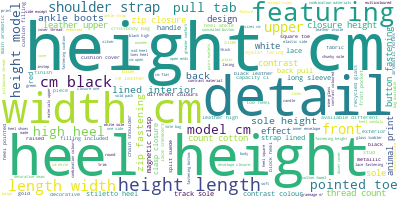

In [ ]:
# Join the different processed texts together.
long_string = ','.join(list(data['description'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

# References:

[1]. Natural Language Processing with Python, by Steven Bird, Ewan Klein and Edward Loper, 2019.

[3]- Hovy, E. H. Automated Text Summarization. In R. Mitkov (ed), The Oxford Handbook of Computational Linguistics, chapter 32, pages 583–598. Oxford University Press, 2005

[4]- Mani, I., House, D., Klein, G., et al. The TIPSTER SUMMAC Text Summarization Evaluation. In Proceedings of EACL, 1999.

[5]- Shashank Kapadia, ["Topic Modeling in Python: Latent Dirichlet Allocation (LDA)"](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0) 2019 Medium post.

[6]- Susan Li, ["Topic Modelling in Python with NLTK and Gensim"](https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21) 2018 Medium post

Kaggle kernels of interest:

https://www.kaggle.com/shivamb/seconds-from-disaster-text-eda-and-analysis

https://www.kaggle.com/caractacus/thematic-text-analysis-using-spacy-networkx